# Find Optimal Decision Thresholds

## Set up the Environment

In [1]:
# Import everything that's needed to run the notebook
import os
import pickle
import dill
import pathlib
import datetime
import random
import time

from IPython.display import display, Markdown, Latex
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import sklearn

import util
import robust
from ipynb.fs.defs.descriptor_based_neural_networks import DescriptorBuilder, dbnn_output, prepare_input
from ipynb.fs.defs.construct_sbnn import SBNNPreprocessor
from sklearn.model_selection import learning_curve

plt.rc('xtick',labelsize=13)
plt.rc('ytick',labelsize=13)

In [2]:
# Define the path to the configuration dictionary
config_path = 'configuration.p'

# Load the configuration dictionary
with open(config_path, 'rb') as f:
    configuration = pickle.load(f)
    
# Get the paths to the relevant directories 
data_directory_path = configuration['data']['directory_path']
classifiers_directory_path = configuration['classifiers']['directory_path']

## Load the Storage of Results and Reports

In [3]:
dbnn_storage = {}

results_directory_path = configuration['results']['directory_path']
path = os.path.join(results_directory_path, 'dbnn_results.p')
with open(path, 'rb') as f:
    dbnn_storage['results'] = pickle.load(f)

reports_directory_path = configuration['reports']['directory_path']
path = os.path.join(reports_directory_path, 'dbnn')
path = os.path.join(path, 'dbnn_reports.p')
with open(path, 'rb') as f:
    dbnn_storage['reports'] = pickle.load(f)

## Load DBNN

In [4]:
with open('dbnns1.p', 'rb') as f:
    dbnns = dill.load(f)

dbnn = dbnns['DBNN']

## Find the Optimal Thresholds

Find the thresholds that minimize $FPR + FNR$ for each sample size, $n=5,10,\ldots,995,1000$.

In [11]:
optimal_tr = {}

In [170]:
s_range = [x/10.0 for x in range(-300, 301, 5)]
k_range = [x/10.0 for x in range(0, 401, 5)] 


for n in range(805, 1001, 5):
    print(n, ' ', end='')
    
    n_range = [n]
    
    # Generate non-normal samples
    nonnormal_samples = util.generate_pearson_nonnormal_samples(s_range, k_range, n_range, 10)

    # Calculate L, the number of normal samples of the same size
    l = len(nonnormal_samples) // len(n_range)
            
    # Generate L normal samples of size n for each n in n_range
    normal_samples = util.generate_normal_samples(n_range, l)
    
    labels = [1 for x in normal_samples] + [0 for x in nonnormal_samples]

    # Unify them
    samples = normal_samples + nonnormal_samples
    
    print(len(samples))
    
    input_samples = prepare_input(samples, dbnn)
    scores = dbnn['neural_net'].predict_proba(input_samples)[:, 1]
    
    fprs, tprs, trs = sklearn.metrics.roc_curve(labels, scores)
    
    best = np.inf
    optimal_tr[n] = None

    for (fpr, tpr, tr) in zip(fprs, tprs, trs):
        # fnr = 1 - tpr
        if fpr + 1 - tpr < best:
            best = fpr + 1 - tpr
            optimal_tr[n] = {'threshold' : tr, 'FPR': fpr, 'FNR' : 1 - tpr}
    
    print(optimal_tr[n])

805  26100
{'threshold': 9.192602398398329e-07, 'FPR': 0.01685823754789272, 'FNR': 0.001455938697317971}
810  26100
{'threshold': 8.641673384539094e-07, 'FPR': 0.016704980842911877, 'FNR': 0.002145593869731788}
815  26100
{'threshold': 7.884670637426447e-07, 'FPR': 0.016168582375478927, 'FNR': 0.0008429118773946032}
820  26100
{'threshold': 7.278758733412076e-07, 'FPR': 0.01793103448275862, 'FNR': 0.0016091954022988686}
825  26100
{'threshold': 6.708571918552293e-07, 'FPR': 0.016934865900383143, 'FNR': 0.0015325670498084198}
830  26100
{'threshold': 6.224619921253599e-07, 'FPR': 0.016398467432950193, 'FNR': 0.0009961685823755007}
835  26100
{'threshold': 5.816988067687288e-07, 'FPR': 0.015708812260536397, 'FNR': 0.0015325670498084198}
840  26100
{'threshold': 5.322000059773852e-07, 'FPR': 0.016551724137931035, 'FNR': 0.0013026819923371846}
845  26100
{'threshold': 4.971545743643862e-07, 'FPR': 0.01578544061302682, 'FNR': 0.0012260536398467359}
850  26100
{'threshold': 4.394239807208343

In [171]:
with open('optimal_thresholds.p', 'wb') as f:
    pickle.dump(optimal_tr, f)

In [6]:
with open('optimal_thresholds.p', 'rb') as f:
    optimal_tr = pickle.load(f)

In [7]:
df = pd.DataFrame(optimal_tr).T

df['n'] = df.index

df.to_csv('optimal_thresholds.csv', index=False)

df

,threshold,FPR,FNR,n
5,5.023253e-01,0.062069,0.299080,5
10,5.982779e-01,0.039770,0.218544,10
15,5.740064e-01,0.036705,0.196552,15
20,5.896870e-01,0.027586,0.182069,20
25,5.694831e-01,0.028736,0.173333,25
...,...,...,...,...
980,6.093051e-08,0.015249,0.001992,980
985,5.361615e-08,0.016398,0.000613,985
990,5.204307e-08,0.015019,0.002529,990
995,4.637449e-08,0.016628,0.000996,995


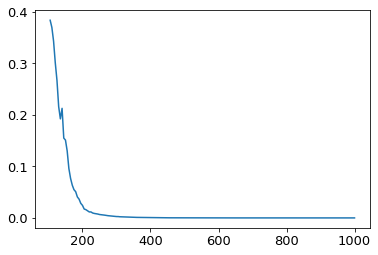

In [335]:
ns = sorted(list(optimal_tr.keys()))
#plt.plot(ns, [optimal_tr[n]['FPR'] + optimal_tr[n]['FNR'] for n in ns])

plt.plot([n for n in ns if 100 < n], [optimal_tr[n]['threshold'] for n in ns if 100 < n ])

It seems that, starting from $n=105$, the optimal threshold, $T_n^{opt}$, drops exponentially as $n$ increases. Let us find the formula.

In [8]:
%load_ext rpy2.ipython

## Inspect how $T_n^{opt}$ depends on $n$

In [9]:
%%R -i df
options(scipen=999)
library(ggplot2)
library(dplyr)
library(ggpubr)
library(latex2exp)
df.fit <- data.frame()

df <- df[df$n >= 300,]

lm.fit <- lm(data=df, log(threshold) ~ n)

summary(lm.fit)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





Call:
lm(formula = log(threshold) ~ n, data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.052307 -0.011456 -0.001444  0.011812  0.071119 

Coefficients:
                Estimate   Std. Error t value            Pr(>|t|)    
(Intercept) -1.217601380  0.005808346  -209.6 <0.0000000000000002 ***
n           -0.015747159  0.000008528 -1846.6 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02061 on 139 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 3.41e+06 on 1 and 139 DF,  p-value: < 0.00000000000000022



R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



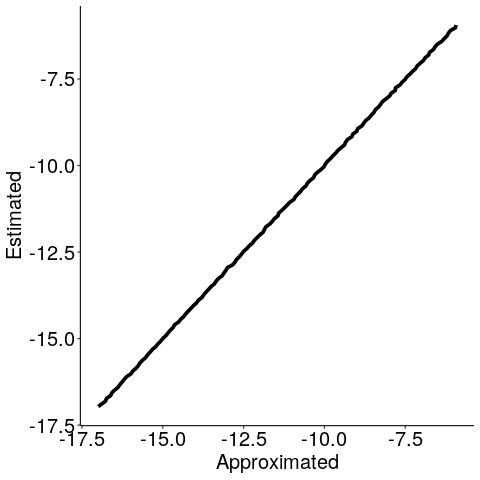

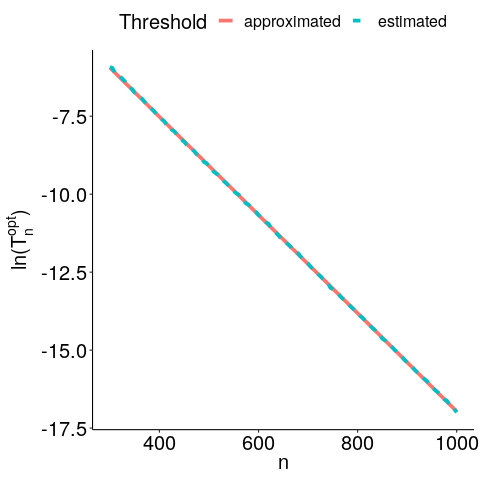

In [10]:
%%R

df1 <- data.frame(approximated=predict(lm.fit),
                  estimated=log(df$threshold),
                  residuals=residuals(lm.fit),
                  n=df$n
                 )

g1 <- ggplot(df1, aes(estimated, approximated)) + 
      geom_line(size=1.75) +
      ylab('Estimated') + 
      xlab('Approximated') +
      theme_pubr() + 
      theme(text = element_text(size=20))
print(g1)

ggsave(g1, filename = 'thresholds.eps')
ggsave(g1, filename = 'thresholds.pdf')

#g2 <- ggplot(df1, aes(log_estimated, residuals)) + geom_point() + geom_hline(yintercept = 0) + theme_pubr()
#print(g2)

#g3 <- ggplot(df1, aes(n, residuals)) + geom_point() + geom_hline(yintercept = 0) + theme_pubr()
#print(g3)
#ggplot(df2)

cbind(df1[4], stack(df1[1:2])) -> df2
colnames(df2) <- c('n', 'threshold', 'Threshold')

g4 <- ggplot(data=df2, aes(n, threshold)) + 
      geom_line(aes(color=Threshold, linetype=Threshold), size=1.75) + 
      xlab(TeX(r'($n$)')) + 
      ylab(TeX(r'($\ln (T_n^{opt})$)')) +
      theme_pubr() +
      theme(text = element_text(size=20))
print(g4)

ggsave(g4, filename = 'thresholds_e_vs_a.eps')
ggsave(g4, filename = 'thresholds_e_vs_a.pdf')

We see the following relation between $n$ and $T_n^{opt}$:
$$\ln T_n^{opt} \approx -1.218 - 0.016n\quad(n\geq 300)$$
or, equivalently:
$$T_n^{opt} \approx 0.296e^{-0.016n}\quad (n\geq 300)$$

## Inspect how $\frac{1}{2}FPR(n)+\frac{1}{2}FNR(n)$ depends on $n$

In [512]:
%%R -i df
df$error_rate = (0.5*(df$FPR + df$FNR))
#df$error_rate = df$FPR / df$FNR

df <- df[df$n >= 300,]

fit <- lm(data=df, log(error_rate) ~ I(1/n))

summary(fit)


Call:
lm(formula = log(error_rate) ~ I(1/n), data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.116931 -0.022897  0.000811  0.026057  0.084636 

Coefficients:
              Estimate Std. Error t value            Pr(>|t|)    
(Intercept)  -5.060921   0.009284 -545.11 <0.0000000000000002 ***
I(1/n)      294.518849   5.070395   58.09 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03729 on 139 degrees of freedom
Multiple R-squared:  0.9604,	Adjusted R-squared:  0.9601 
F-statistic:  3374 on 1 and 139 DF,  p-value: < 0.00000000000000022



R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



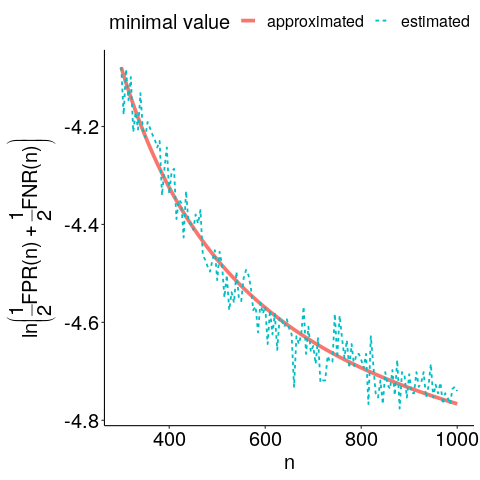

In [516]:
%%R
library(latex2exp)

df5 <- data.frame(n=df$n, approximated=predict(fit), estimated=log(df$error_rate), residuals=residuals(fit))

df6 <- cbind(df5[c(1, 4)], stack(df5[2:3]))
colnames(df6)[3:4] <- c("error_rate", "value")

g <- ggplot(df6, aes(n, error_rate)) + 
     geom_line(aes(color=value, linetype=value, size=value)) + 
     theme_pubr() +
     theme(text = element_text(size=20)) +
     scale_size_discrete(range = c(1.75, 0.85)) + 
     ylab(TeX(r'($\ln \left(\frac{1}{2}FPR(n)+\frac{1}{2}FNR(n)\right)$)')) +
     labs(color="minimal value", linetype="minimal value", size="minimal value")

print(g)

ggsave(g, filename="posterior.eps")
ggsave(g, filename="posterior.pdf")

## Inspect how $\frac{FPR(n)}{FNR(n)}$ depends on $n$

In [518]:
%%R -i df

df$error_ratio = df$FPR / df$FNR

df <- df[df$n >= 300,]

fit <- lm(data=df, log(error_ratio) ~ poly(n, 2))

summary(fit)


Call:
lm(formula = log(error_ratio) ~ poly(n, 2), data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.81723 -0.26153 -0.01271  0.23657  1.31495 

Coefficients:
            Estimate Std. Error t value            Pr(>|t|)    
(Intercept)  2.01907    0.03087  65.402 <0.0000000000000002 ***
poly(n, 2)1  5.29948    0.36658  14.456 <0.0000000000000002 ***
poly(n, 2)2 -0.98336    0.36658  -2.683              0.0082 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3666 on 138 degrees of freedom
Multiple R-squared:  0.6104,	Adjusted R-squared:  0.6047 
F-statistic: 108.1 on 2 and 138 DF,  p-value: < 0.00000000000000022



It seems that

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



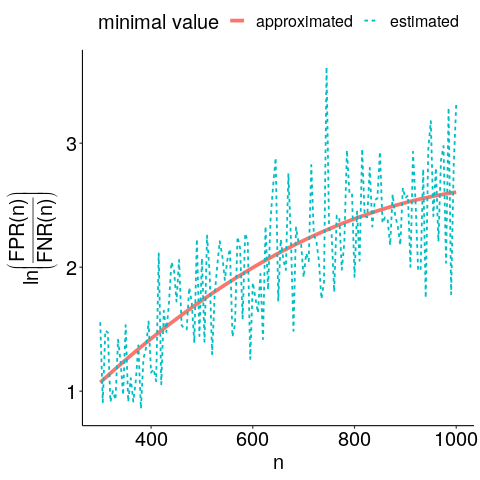

In [519]:
%%R
df5 <- data.frame(n=df$n, approximated=predict(fit), estimated=log(df$error_ratio), residuals=residuals(fit))

df6 <- cbind(df5[c(1, 4)], stack(df5[2:3]))
colnames(df6)[3:4] <- c("ratio_value", "value")

g <- ggplot(df6, aes(n, ratio_value)) + 
     geom_line(aes(color=value, linetype=value, size=value)) + 
     scale_size_discrete(range = c(1.75, 0.85)) + 
     ylab(TeX(r'($\ln \left(\frac{FPR(n)}{FNR(n)}\right)$)')) +
     theme_pubr() + 
     theme(text = element_text(size=20)) + 
     labs(color="minimal value", linetype="minimal value", size="minimal value")


print(g)

ggsave(g, filename="ratio.eps")
ggsave(g, filename="ratio.pdf")